In [ ]:
! pip install deepchem  
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv # 데이터 불러오기
# ! pip install tensorflow~=2.4
! pip install tensorflow==1.15
!pip install kora
! pip install MolVS
! pip install keras==1.2.2

     |████████████████████████████████| 552 kB 5.1 MB/s 
--2021-12-04 13:25:59--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.01s   

2021-12-04 13:26:00 (6.66 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]

     |████████████████████████████████| 412.3 MB 27 kB/s 
     |████████████████████████████████| 3.8 MB 46.5 MB/s 
     |████████████████████████████████| 503 kB 51.7 MB/s 
     |████████████████████████████████| 50 kB 6.4 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=0d65de8094f7ea852

In [ ]:
!curl https://raw.githubusercontent.com/pdcoded/fox/master/tox21_sdf/tox21_10k_data_all.sdf -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 23.5M  100 23.5M    0     0  47.4M      0 --:--:-- --:--:-- --:--:-- 47.4M


In [ ]:
import kora.install.rdkit

Toxicity

In [ ]:
#Pandas and Numpy
import pandas as pd
import numpy as np
#RDkit for fingerprinting and cheminformatics
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, rdMolDescriptors
#MolVS for standardization and normalization of molecules
import molvs as mv
#Keras for deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ReduceLROnPlateau

from keras.regularizers import WeightRegularizer
from keras.optimizers import SGD # from keras.optimizers import SGD --> from keras.optimizers import gradient_descent_v2 
#SKlearn for metrics and datasplits

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
#Matplotlib for plotting
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [ ]:
"""
from rdkit import Chem
import pandas as pd
filename = "tox21_10k_data_all.sdf"
basename = filename.split(".")[0]
collector = []
sdprovider = Chem.SDMolSupplier(filename)
for i,mol in enumerate(sdprovider):
    try:
        moldict = {}
        moldict['smiles'] = Chem.MolToSmiles(mol)
        #Parse Data
        for propname in mol.GetPropNames():
            moldict[propname] = mol.GetProp(propname)
        collector.append(moldict)
    except:
        print("Molecule %s failed"%i)
data = pd.DataFrame(collector)
data.to_csv(basename + '_pandas.csv')
"""

'\nfrom rdkit import Chem\nimport pandas as pd\nfilename = "tox21_10k_data_all.sdf"\nbasename = filename.split(".")[0]\ncollector = []\nsdprovider = Chem.SDMolSupplier(filename)\nfor i,mol in enumerate(sdprovider):\n    try:\n        moldict = {}\n        moldict[\'smiles\'] = Chem.MolToSmiles(mol)\n        #Parse Data\n        for propname in mol.GetPropNames():\n            moldict[propname] = mol.GetProp(propname)\n        collector.append(moldict)\n    except:\n        print("Molecule %s failed"%i)\ndata = pd.DataFrame(collector)\ndata.to_csv(basename + \'_pandas.csv\')\n'

In [ ]:
def sdf_to_df(filepass):
    mols = [mol for mol in Chem.SDMolSupplier(filepass) if mol is not None]
    for id, mol in enumerate(mols):
        if id == 0:
            dicts = mol.GetPropsAsDict()
            df = pd.DataFrame(dicts, index=[id,])
        else:
            dicts = mol.GetPropsAsDict()
            dfplus = pd.DataFrame(dicts, index=[id,])
            df = df.append(dfplus)
    return mols, df

train_x, train_df = sdf_to_df('./tox21_10k_data_all.sdf')

In [ ]:
train_x[0]

In [ ]:
mol1 = train_x[1]
#print(Chem.MolToMolBlock(mol1))
print(Chem.MolToSmiles(mol1))

O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(Br)c([O-])c(Br)cc12.[Na+].[Na+]


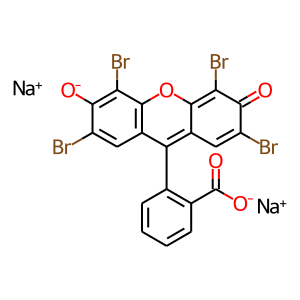

In [ ]:
from IPython.display import SVG
from rdkit.Chem.Draw import rdMolDraw2D
# SVG(Chem.MolToSVG(mol1))
drawer = rdMolDraw2D.MolDraw2DSVG(300,300)
drawer.DrawMolecule(mol1)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
SVG(svg)

In [ ]:
train_df.columns

Index(['Formula', 'FW', 'DSSTox_CID', 'SR-HSE', 'NR-AR', 'SR-ARE',
       'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP', 'NR-ER',
       'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD'],
      dtype='object')

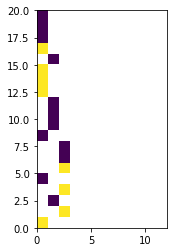

In [ ]:
import matplotlib.pyplot as plt

hoge = train_df.iloc[0:20,3:15].to_numpy()
dumb = plt.imshow(hoge*255,extent=[0,12,0,20])

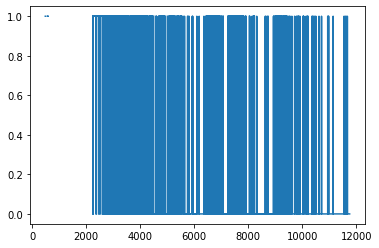

In [ ]:
plt.plot(train_df['SR-MMP'])

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Reshape, Dropout, Activation

Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
from rdkit.Chem import AllChem
n0 = 1000
n_train = 8000
n_test = 2000

tmp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in train_x[n0:(n0+n_train)]]
x_train = np.stack(tmp,0)
y_train = train_df['SR-MMP'][n0:(n0+n_train)]
y_train[np.isnan(y_train)] = 0.5

tmp = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024) for mol in train_x[(n0+n_train):(n0+n_train+n_test)]]
x_test = np.stack(tmp,0)
y_test = train_df['SR-MMP'][(n0+n_train):(n0+n_train+n_test)]
y_test[np.isnan(y_test)] = 0.5

In [ ]:
print(np.mean(y_train))
print(np.mean(y_test))

0.343625
0.05175


In [ ]:
model1 = Sequential()
#model1.add(Dense(16, input_shape=(1024,), activation='relu'))
#model1.add(Dropout(0.5))
#model1.add(Dense(16, activation='softmax'))
#model1.add(Dense(16, activation='softmax'))
#model1.add(Dense(1, activation='softmax'))
#model1.summary()

model1.add(Dense(16, input_shape=(1024,),activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(16, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1, activation='softmax'))
model1.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_31 (Dense)                 (None, 16)            16400       dense_input_9[0][0]              
____________________________________________________________________________________________________
dropout_13 (Dropout)             (None, 16)            0           dense_31[0][0]                   
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 16)            272         dropout_13[0][0]                 
____________________________________________________________________________________________________
dropout_14 (Dropout)             (None, 16)            0           dense_32[0][0]                   
___________________________________________________________________________________________

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [ ]:
#reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5,patience=50, min_lr=0.00001, verbose=1)
#Training
#history = model1.fit(x_train, y_train, nb_epoch=200, batch_size=500, validation_data=(x_test,y_test), callbacks=[reduce_lr])
model1.fit(x_train, y_train,
          nb_epoch=100,
          batch_size=500,
          )

Epoch 1/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 2/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 3/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 4/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 5/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 6/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 7/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1282     
Epoch 8/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 9/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1282     
Epoch 10/100
8000/8000 [==============================] - 0s - loss: 10.4642 - acc: 0.1283     
Epoch 11/100
8000/8000 [=========================

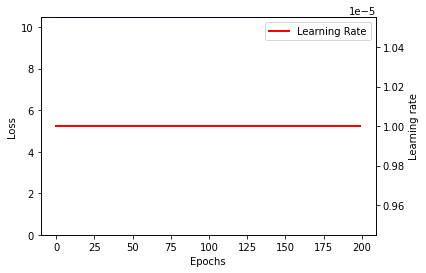

In [ ]:
def plot_history(history):
    lw = 2
    fig, ax1 = plt.subplots()
    ax1.plot(history.epoch, history.history['binary_crossentropy'],c='b', label="Train", lw=lw)
    ax1.plot(history.epoch, history.history['val_loss'],c='g', label="Val", lw=lw)
    plt.ylim([0.0, max(history.history['binary_crossentropy'])])
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax2 = ax1.twinx()
    ax2.plot(history.epoch, history.history['lr'],c='r', label="Learning Rate", lw=lw)
    ax2.set_ylabel('Learning rate')
    plt.legend()
    plt.show()
plot_history(history)

In [ ]:
y_pred = model1.predict(x_test)
print(y_pred)

[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [1.]]


In [ ]:
y_train

1000    0.5
1001    0.5
1002    0.5
1003    0.5
1004    0.5
       ... 
8995    0.0
8996    0.5
8997    0.0
8998    0.5
8999    0.5
Name: SR-MMP, Length: 8000, dtype: float64

In [ ]:
print(y_train.unique())
print(y_test.unique())

[0.5 1.  0. ]
[0.  0.5 1. ]


In [ ]:
np.unique(y_pred)

array([1.], dtype=float32)

In [ ]:
def show_auc(model):
    pred_train = model.predict(x_train)
    #pred_train = pd.DataFrame(pred_train)
    # pred_val = model.predict(x_val)
    pred_test = model.predict(x_test)
    #pred_test = pd.DataFrame(pred_test)
    auc_train = roc_auc_score(y_train, pred_train)
    # auc_val = roc_auc_score(y_val, pred_val)
    auc_test = roc_auc_score(y_test, pred_test)
    print("AUC, Train:%0.3F Test:%0.3F Val:%0.3F"%(auc_train, auc_test, auc_val))
    fpr_train, tpr_train, _ =roc_curve(y_train, pred_train)
    fpr_val, tpr_val, _ = roc_curve(y_val, pred_val)
    fpr_test, tpr_test, _ = roc_curve(y_test, pred_test)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='b',lw=lw, label='Train ROC (area = %0.2f)'%auc_train)
    plt.plot(fpr_val, tpr_val, color='g',lw=lw, label='Val ROC (area = %0.2f)'%auc_val)
    plt.plot(fpr_test, tpr_test, color='r',lw=lw, label='Test ROC (area = %0.2f)'%auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of %s'%prop)
    plt.legend(loc="lower right")
    plt.interactive(True)
    plt.show()
show_auc(model1)

ValueError: ignored